In [30]:
import pandas as pd
from sklearn import decomposition
import matplotlib.pyplot as plt
import sklearn
import ast
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf

# %matplotlib qt

In [17]:
df_movie = pd.read_csv("Expanded_data/big_data_final.tsv",sep='\t',low_memory=False)

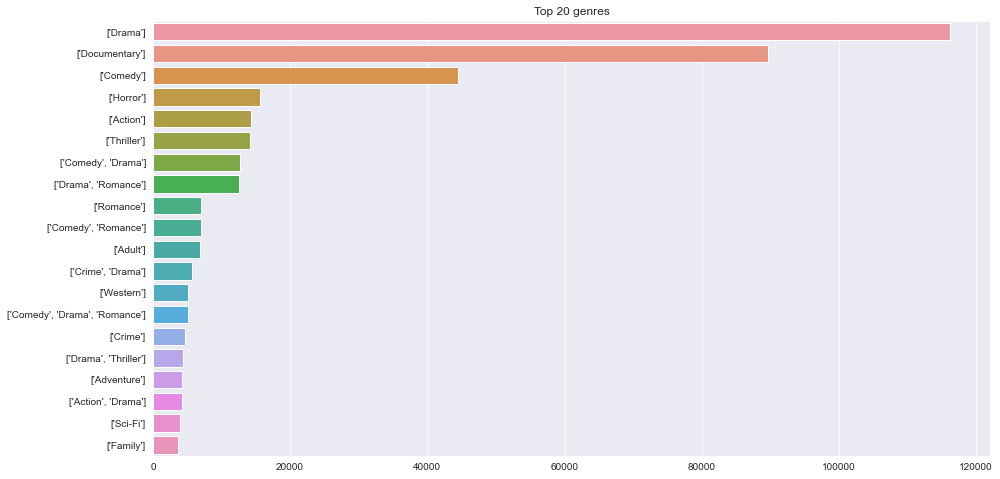

In [31]:
df_genre = df_movie.copy()
df_genre.dropna(subset=['Movie genres names'], inplace=True)
count_genre = df_genre['Movie genres names'].value_counts()
plt.figure(figsize=(15,8))
ax = sns.barplot(x=count_genre.values[0:20], y=count_genre.index[0:20]).set(title='Top 20 genres')
plt.show()

### Create dummies for genres

In [129]:
data = df_movie[['Movie genres names', 'averageRating', 'inflation corrected budget', 'inflation corrected revenue']].dropna()

In [130]:
# incorporate dummies into data for genres
# recreate genre lists from string format
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()

Drama          2603
Comedy         1874
Action         1395
Crime          1021
Romance         905
Adventure       877
Thriller        870
Horror          592
Mystery         486
Fantasy         442
Sci-Fi          432
Biography       314
Family          250
History         177
Music           167
Sport           120
War             106
Musical          60
Animation        50
Western          45
Documentary      39
Adult             2
News              2
dtype: int64

In [131]:
def incorporate_genre_dummies(data):
    # transform into dummies
    movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
    df = pd.get_dummies(pd.DataFrame(movie_genres))
    df.columns = df.columns.str.split("_").str[-1]

    # need to sum similarly named columns due to unwanted effect of previous computation
    df = df.groupby(level=0, axis=1).sum()
    genre_names = df.columns

    # adding to data and removing old genre column
    data[df.columns] = df.values
    data = data.drop('Movie genres names', axis = 1)

    # rename problematic Sci-Fi column name
    data.rename(columns={'Sci-Fi' : 'SciFi'}, inplace = True)
    genre_names = [x if x != 'Sci-Fi' else 'SciFi' for x in genre_names]

    return data, genre_names

In [132]:
data, genre_names = incorporate_genre_dummies(data)

In [133]:
data.rename(columns={'inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)

In [134]:
data['log_revenue'] = np.log(data['corr_revenue'])

In [135]:
data.head(2)

,averageRating,corr_budget,corr_revenue,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,...,Musical,Mystery,News,Romance,SciFi,Sport,Thriller,War,Western,log_revenue
33,7.6,4.578426e+06,4.692887e+06,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,15.361558
225,7.0,7.431127e+07,2.694641e+08,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,19.411946


### Linear regression: average ratings, revenue

In [136]:
mod = smf.ols(formula="averageRating ~ Action + Adult + Adventure +\
       Animation + Biography + Comedy + Crime + Documentary + Drama +\
       Family + Fantasy + History + Horror + Music + Musical + Mystery +\
       News + Romance + SciFi + Sport + Thriller + War + Western", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     40.79
Date:                Tue, 29 Nov 2022   Prob (F-statistic):          3.44e-167
Time:                        16:43:31   Log-Likelihood:                -6940.4
No. Observations:                5018   AIC:                         1.393e+04
Df Residuals:                    4994   BIC:                         1.409e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.4051      0.061    105.387      

**Biography, Documentary, Drama, Western** are significantly driving the grades upwards, while **Action, Comedy, Family, Horror and Romance** drive it downwards.

In [137]:
mod = smf.ols(formula="log_revenue ~ Action + Adult + Adventure + \
       Animation + Biography + Comedy + Crime + Documentary + Drama +\
       Family + Fantasy + History + Horror + Music + Musical + Mystery +\
       News + Romance + SciFi + Sport + Thriller + War + Western", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     19.32
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           5.99e-76
Time:                        16:43:32   Log-Likelihood:                -10446.
No. Observations:                5018   AIC:                         2.094e+04
Df Residuals:                    4994   BIC:                         2.110e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      17.0126      0.122    139.190      

**Action, Adventure, Biography, Family, Mystery, Thriller** are significantly driving the revenue upwards, while **Animation, Documentary, Drama and Horror** drive it downwards.

Some genres have a similar effect on grades and revenue, like **Biography (upward) and Horror (downward)**. While **Action** movies are generally associated to a bad movie, it paradoxically generates a lot of revenue. On the contrary, while **Documentaries** are well graded, they produce little revenue.

In [138]:
mod = smf.ols(formula="log_revenue ~ Comedy*Romance + \
                                    Comedy*Drama + \
                                    Drama*Romance ", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     21.50
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           4.44e-25
Time:                        16:43:32   Log-Likelihood:                -10596.
No. Observations:                5018   AIC:                         2.121e+04
Df Residuals:                    5011   BIC:                         2.125e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         17.9105      0.058    308.

Interestingly, for very common genre associations, we observe that their combination has a positive effect on revenue, while the genre alone tend to provoke a decrease.

In [139]:
mod = smf.ols(formula="averageRating ~ Comedy*Romance + \
                                    Comedy*Drama + \
                                    Drama*Romance ", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     112.1
Date:                Tue, 29 Nov 2022   Prob (F-statistic):          3.86e-133
Time:                        16:43:33   Log-Likelihood:                -7056.3
No. Observations:                5018   AIC:                         1.413e+04
Df Residuals:                    5011   BIC:                         1.417e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.1477      0.029    214.

No such effect can be seen (with any significance) on the average IMDB rating, which implies that revenue is driving the market.

### Boxplots

In [140]:
# create a log distribution for budget
data['log_budget'] = np.log(data['corr_budget'])

In [143]:
budget, revenue, rating = list(), list(), list()
for genre in genre_names:
    budget.append(data[data[genre] == 1]['log_budget'])
    revenue.append(data[data[genre] == 1]['log_revenue'])
    rating.append(data[data[genre] == 1]['averageRating'])

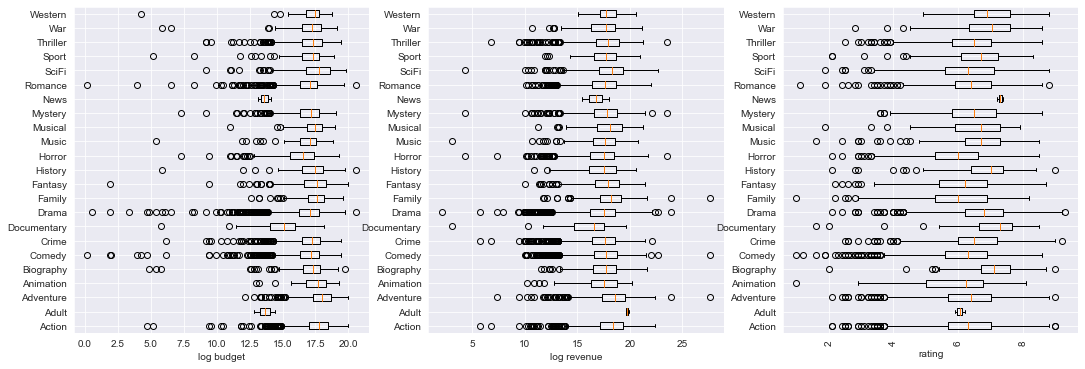

In [163]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(18,6))
axs[0].boxplot(budget, labels=genre_names, vert = False)
axs[0].set_xlabel('log budget')
axs[1].boxplot(revenue, labels=genre_names, vert = False)
axs[1].set_xlabel('log revenue')
axs[2].boxplot(rating, labels=genre_names, vert = False)
axs[2].set_xlabel('rating')
plt.xticks(rotation=90)
plt.show()

Useful ?

### Clustering pipeline (and dimensionality reduction)
As revenue and budget are heavy-tailed, we take their log (done previously), which transforms it into a gaussian-like distribution, which we can then standardize. Average ratings are already gaussian-like; we also standardize them.

In [180]:
def standardize(data):
    return (data - np.nanmean(data)) / np.std(data)

In [181]:
# create standardize distribution of (log) distributions
data['log_budget'] = standardize(data['corr_budget'])
data['log_revenue'] = standardize(data['log_revenue'])
data['averageRating'] = standardize(data['averageRating'])

# remove unwanted column for clustering
data.drop(['corr_budget', 'corr_revenue'], axis = 1, inplace=True)

,averageRating,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Mystery,News,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget
33,1.132268,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,-1.029493,-0.811477
225,0.561661,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.970954,0.539489


Now we can perform dimensionality reduction

In [195]:
pca = decomposition.PCA(n_components=10)
pca.fit(data.T)

PCA(n_components=10)

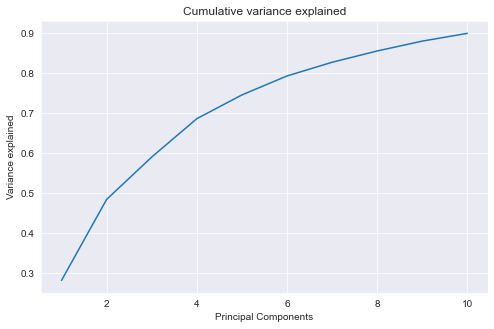

In [196]:
# compute cumulative explained variance
plt.figure(figsize=(8,5))
plt.title('Cumulative variance explained')
sns.lineplot(x = np.arange(1,11,1), y = np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Components')
plt.ylabel('Variance explained')
plt.show()

With 10 components, we can capture 90% of the variance in the data, but we already capture 80% with 6 components.
Let's observe some 2D principal components plots.

In [316]:
def plot_components(comp, color = None):
    if color is None : color = 'darkgreen'
    fig, axs = plt.subplots(ncols=3, figsize=(10,5))
    axs[0].scatter(comp[0,:], comp[1,:], c = color)
    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')
    axs[1].scatter(comp[0,:], comp[2,:], c = color)
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC3')
    axs[2].scatter(comp[1,:], comp[2,:], c = color)
    axs[2].set_xlabel('PC2')
    axs[2].set_ylabel('PC3')
    plt.suptitle('Principal components subplots')
    plt.show()

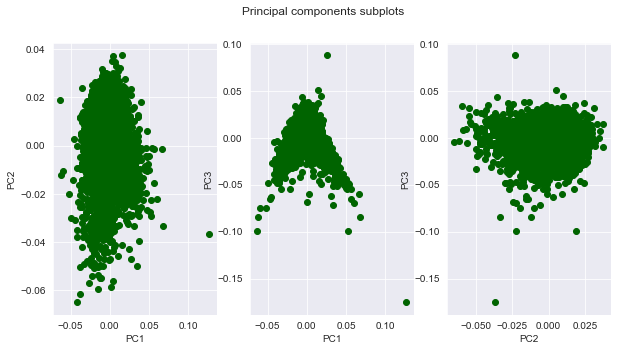

In [317]:
plot_components(pca.components_)

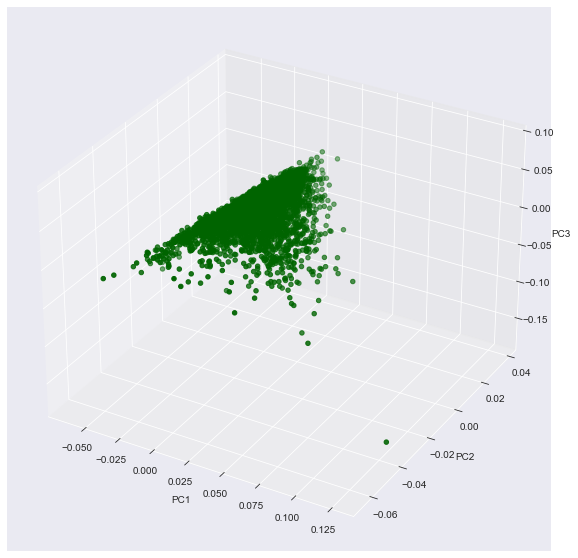

In [314]:
fig = plt.figure(figsize =(10,10))
ax = plt.axes(projection='3d')

ax.scatter(pca.components_[0,:], pca.components_[1,:], pca.components_[2,:], color = 'darkgreen')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

### Clustering

In [245]:
from sklearn.cluster import KMeans, DBSCAN

# select components of interest
PCs = pca.components_[:6,:].T
PCs.shape

(5018, 6)

In [304]:
def silhouette(data, labels):
    """ Returns silhouette score of data [n_samples x n_features]"""
    return sklearn.metrics.silhouette_score(data, labels=labels)

def plot_silhouettes(x, silhouettes, param, clustering_type, n_clusters = None):
    """ Plot silhouette score """
    fig, ax = plt.subplots()
    ax.plot(x, silhouettes)
    if n_clusters is not None:
        for n, x_, y_ in zip(n_clusters, x, silhouettes):
            ax.text(x_, y_, str(n) + ' cl.', fontsize = 12)
    fig.suptitle(f'Silhouette score on clustering method: {clustering_type}')
    ax.set_xlabel(param)
    ax.set_ylabel('Silhouette score')
    plt.show()

In [264]:
N_list = np.arange(2,11,1)
kmeans_silhouettes = list()

for n in N_list:
    kmeans = KMeans(n_clusters=n, random_state=0).fit(PCs)
    kmeans_silhouettes.append(silhouette(data, kmeans.labels_))

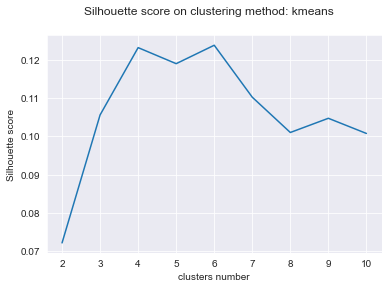

In [292]:
plot_silhouettes(N_list, kmeans_silhouettes, 'clusters number', 'kmeans')

In [278]:
eps_list = np.arange(0.01,0.02,0.001)
DBSCAN_silhouettes, n_clusters = list(), list()

for eps in eps_list:
    dbscan = DBSCAN(eps, min_samples = 3).fit(PCs)
    DBSCAN_silhouettes.append(silhouette(data, dbscan.labels_))
    # get number of clusters, taken from sklearn tutorial
    n_clusters.append(len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0))

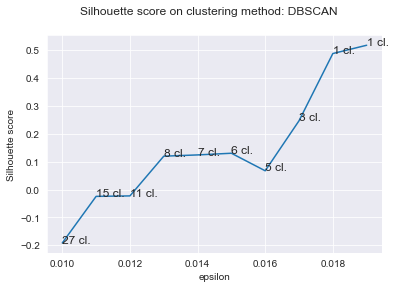

In [305]:
plot_silhouettes(eps_list, DBSCAN_silhouettes, 'epsilon', 'DBSCAN', n_clusters)

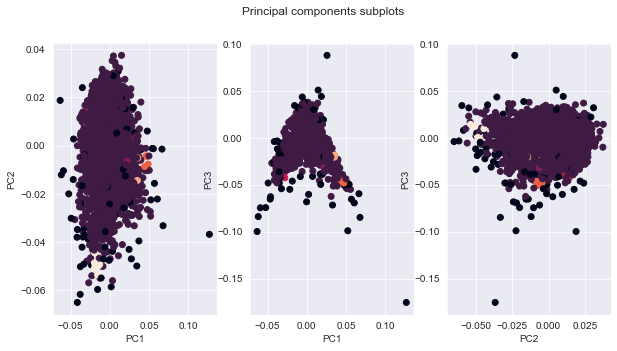

In [319]:
dbscan = DBSCAN(0.015, min_samples = 3).fit(PCs)
plot_components(PCs.T, color = dbscan.labels_)

On y voit pas grand chose oups